In [885]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelmin
import pandas as pd
from collections import Counter
import os

from pathlib import Path

from scipy import signal
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import signal

import pickle 

from sklearn.neighbors import KNeighborsRegressor



In [1098]:
#auscultatory_sbp = []
#auscultatory_pressure = []
everything = {}

path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"

participants_data =  path_aurora_dataset / "participants.tsv"

basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t').dropna(subset=["waveform_file_path"]).dropna(subset=["sbp"]).dropna(subset=["dbp"]) 

In [755]:

def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]

def reject_outliers(data):
    #return data[abs(data - np.mean(data)) < 0.3 * np.mean(data)]
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # ADD THE DROPPING DWOAN AND GETMIN BELLOW a LINE
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    # juts deleted stuff from both lists if its in tht 40 range 
    # THIS IS THE MOST IMPORTANT 
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))
    print("diffrences ", min_peaks, diffrences_new_min)

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    print("YO ",diffrences_new_min)
    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]


            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):
                # overlapped_means[f"pulse {i}"] = list(y_rotated)[:int(mean_new_min)]

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                #overlapped_means[f"pulse {i}"] = list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)])
                #  gave error: https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)
    # WORKS STAY LIKE TAHTA^^^^  MAKES THE MEAN THE HIGHEST VLAUE , 
    #maybe later make it wider but for now it would work the same!
    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    # print(all_overlaps_means)
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y


def get_person_activity_data(person_id):
    filler_to_person = basic_mesures_data[basic_mesures_data["pid"] == person_id]
    

    for each_path in filler_to_person["waveform_file_path"]:
        each_path_50_cords = get_50_avg_coordinates(path_aurora_dataset/each_path)
        # auscultatory_pressure.append(each_path_50_cords)
        everything[each_path] = [each_path_50_cords, filler_to_person[filler_to_person["waveform_file_path"] == each_path]["sbp"], 
                                 filler_to_person[filler_to_person["waveform_file_path"] == each_path]["dbp"] ]

        


    #return  filler_to_person["sbp"]


In [771]:
#seeing the bad keys

# for path in bad_keys:
#     #print("/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/"+path)
        
#     print(get_50_avg_coordinates("/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/"+path))

In [715]:
# this will be main loop ---- later.... To run on who data set


# for person in sorted(os.listdir(path_aurora_dataset/"measurements_auscultatory")):
#     if "a" in person:
        
#         get_person_activity_data(person)



In [586]:
# ^^ to put into pickle
with open('measurements_auscultatory_dictionary_439_end.pkl', 'wb') as f:
    pickle.dump(everything, f)

In [902]:
dictionary_path = "/Users/cslinxs/Desktop/all_weeks/summer24-lab/measurements_auscultatory_dictionary_ALL.pkl"

with open(dictionary_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)

In [906]:
#getting rid of bad keys(might need to go forever bc the graph is too messy
auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]

bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]

#double checking
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        print("um")

[]


In [945]:
# here i want to fillter based on activity!!
data_name = "Calibration_start"#"Static_seated_challenge"#"Exercise_challenge"#"Calibration_start"
auscultatory_pressure= []
auscultatory_sbp  = []


for key, each_grouping in all_auscultatory_dic.items():
    if "Calibration_start" in key :

    #if int(each_grouping[1]) in range(140,160):
        auscultatory_pressure.append(each_grouping[0])
        auscultatory_sbp.append(each_grouping[1])

In [1036]:
def get_person_data(PID):
    return ([([each_data[0] for each_data in item.values()]) for item in group_ppl[PID]], [([each_data[1] for each_data in item.values()][0]) for item in group_ppl[PID]])


18 2
2 18
mean abs error 3.5
RMS 3.913118960624632
r2  -1.0247933884297522


Text([140.25], [140.], 'r2 -1.02')

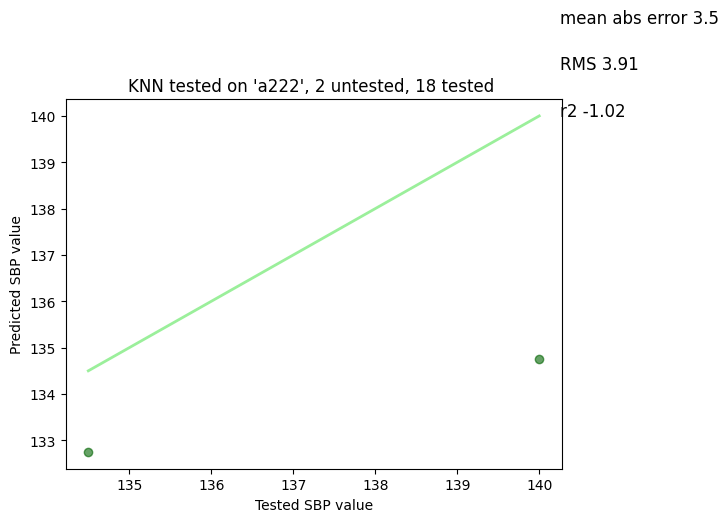

In [1094]:
neigh = KNeighborsRegressor(n_neighbors=2)


all_points = np.array(auscultatory_pressure)
all_points = all_points.reshape(all_points.shape[0], -1)
# auscultatory_sbp = np.array(auscultatory_sbp)
# auscultatory_sbp=auscultatory_sbp.reshape(1,-1) 
# X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_sbp, test_size=0.3)

print(len(X_train),len(X_test))

tester_pid = "a222"
X_train =  np.array(get_person_data(tester_pid)[0][2:])
X_train = X_train.reshape(X_train.shape[0], -1)

X_test= np.array(get_person_data(tester_pid)[0][:2])
X_test = X_test.reshape(X_test.shape[0], -1)


Y_train= get_person_data(tester_pid)[1][2:]

Y_test= np.array(get_person_data(tester_pid)[1][:2])
Y_test = Y_test.reshape(Y_test.shape[0], -1)
print(len(Y_test),len(Y_train))
the_fit= neigh.fit(X_train, Y_train)

y_predict= neigh.predict(X_test)#, auscultatory_sbp[10])


rms = root_mean_squared_error(Y_test, Y_test)
print("mean abs error",mean_absolute_error(Y_test, y_predict))
print("RMS",root_mean_squared_error(Y_test, y_predict))
print("r2 ",r2_score(Y_test, y_predict))


plt.scatter(Y_test, y_predict,  color="darkgreen",  alpha=0.6 )
plt.plot(Y_test, Y_test, color="lightgreen", linewidth=2, alpha=0.9)

plt.title(f"KNN tested on '{tester_pid}', {len(Y_test)} untested, {len(Y_train)} tested ")
#plt.text(2, 2, 'text', size=15, color='purple')
#plt.text(0.1, 0.9, 'text', size=15, color='purple')

plt.xlabel("Tested SBP value")
plt.ylabel("Predicted SBP value")




plt.text(max(Y_test)+0.25, max(Y_test)+2,s=f"mean abs error {mean_absolute_error(Y_test, y_predict)}", fontsize=12)
plt.text(max(Y_test)+0.25, max(Y_test)+1, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
plt.text(max(Y_test)+0.25, max(Y_test), s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)
# plt.annotate('Something', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

hi  0.1243332930763853
mean abs error 14.061508598147464
RMS 17.61080178879359
r2  0.06775572809942576
y_predict mean 127.69061928374093


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


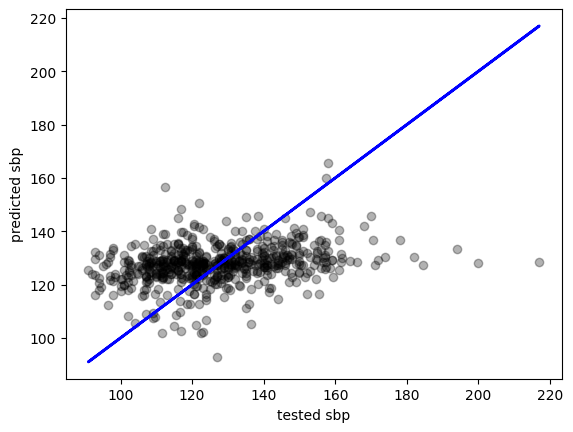

In [982]:
# auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()][:1000]
# auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()][:1000]

# auscultatory_pressure= auscultatory_pressure[:100]
# auscultatory_sbp = auscultatory_sbp[:100]

all_points = np.array(auscultatory_pressure)
all_points = all_points.reshape(all_points.shape[0], -1)





X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_sbp, test_size=0.3)
model = LinearRegression()


the_fit= model.fit(X_train, Y_train)
score  = model.score(all_points, auscultatory_sbp)
print("hi ",score)
y_predict = model.predict(X_test)


# for i in range(len(y_predict)):
#     plt.vlines(x = Y_test[i], ymin =y_predict[i] , ymax = Y_test[i], alpha=0.1)


rms = root_mean_squared_error(Y_test, Y_test)
print("mean abs error",mean_absolute_error(Y_test, y_predict))
print("RMS",root_mean_squared_error(Y_test, y_predict))
print("r2 ",r2_score(Y_test, y_predict))


plt.scatter(Y_test, y_predict,  color="black",  alpha=0.3 )
plt.plot(Y_test, Y_test, color="blue", linewidth=2)

#plt.title(f"{data_grouping} tested on {len(Y_test)} test vs {len(Y_train)} graphs")

plt.xlabel("tested sbp")
plt.ylabel("predicted sbp")

print("y_predict mean",  np.mean(y_predict))

In [1118]:
# basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t').dropna(subset=["waveform_file_path"]).dropna(subset=["sbp"]).dropna(subset=["dbp"]) 

In [1117]:
participants_csv_data = pd.read_csv(participants_data,sep = '\t')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', False)

#participants_csv_data = participants_csv_data[participants_csv_data["self_report_htn"]=="unmanaged"]

participants_csv_data = participants_csv_data[participants_csv_data["self_report_htn"].isin(["managed","unmanaged"])]


participants_csv_data = participants_csv_data[participants_csv_data["pid"].str.contains('a')]
participants_csv_data


,pid,n_meas_inlab,n_meas_ambulatory,aurora_size,fitzpatrick_scale,bp_cuff_arm,in_feature_table,age,height,weight,gender,self_report_htn,high_blood_pressure,coronary_artery_disease,diabetes,arrythmia,previous_heart_attack,previous_stroke,heart_failure,aortic_stenosis,valvular_heart_disease,other_cv_diseases,cvd_meds
551,a003,20,NaN,L,1.0,R,0,78.0,68.0,260.0,M,managed,1,0,0,1,0,0,0,0,0,0,1
556,a008,20,NaN,S,2.0,L,1,30.0,63.0,110.0,F,managed,0,0,0,0,0,0,0,0,0,1,0
562,a014,20,NaN,M,3.0,L,1,37.0,72.0,235.0,M,managed,0,0,0,0,0,0,0,0,0,0,0
563,a015,20,NaN,S,3.0,L,0,21.0,67.0,111.0,M,managed,0,0,0,0,0,0,0,0,0,0,0
564,a016,20,NaN,M,2.0,L,0,62.0,65.0,157.0,F,managed,1,0,1,0,0,0,0,0,0,0,1
567,a019,20,NaN,M,3.0,L,1,57.0,68.0,175.0,M,managed,1,0,0,0,0,0,0,0,0,0,1
572,a024,20,NaN,M,2.0,R,1,66.0,68.0,170.0,M,managed,1,0,0,0,0,0,0,0,0,0,1
580,a032,20,NaN,L,5.0,R,1,28.0,71.0,290.0,M,unmanaged,1,0,0,0,0,0,0,0,0,0,1
586,a038,11,NaN,L,1.0,R,1,57.0,69.0,250.0,M,managed,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t').dropna(subset=["waveform_file_path"]).dropna(subset=["sbp"]).dropna(subset=["dbp"]) 

In [947]:
group_ppl = {}
for key, each_grouping in list(all_auscultatory_dic.items()):
    person_id = key.split("_")[1].split("/")[1]
    if not(person_id in group_ppl):
        group_ppl[person_id] = []
    group_ppl[person_id].append({key: each_grouping})
    

    #print(key.split("_")[1].split("/")[1])
